# **Transfer Learning: Vision Transformers**
## **Image Classification**


In [15]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [16]:
import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import transforms as T

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [17]:
# Das Model soll auf Huggingface hochgeladen werden, weswegen wir hier das Login brauchen.
notebook_login()

Token has not been saved to git credential helper.


In [18]:
# Datensatz laden 
dataset = load_dataset("imagefolder", data_dir="animals")
dataset

Resolving data files:   0%|          | 0/5400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})

In [19]:
# Infos aus erstem Beispiel anzeigen lassen

dataset['train'][0]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1640x1025>,
 'label': 0}

In [20]:
# Die verscheidenen Klassen-IDs anzeigen
label_names = dataset['train'].features['label'].int2str
label_names

<bound method ClassLabel.int2str of ClassLabel(names=['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra'], id=None)>

In [21]:
#Anzahl und die Klassen selber anzeigen
labels = dataset['train'].unique('label')
print(len(labels),labels)

90 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


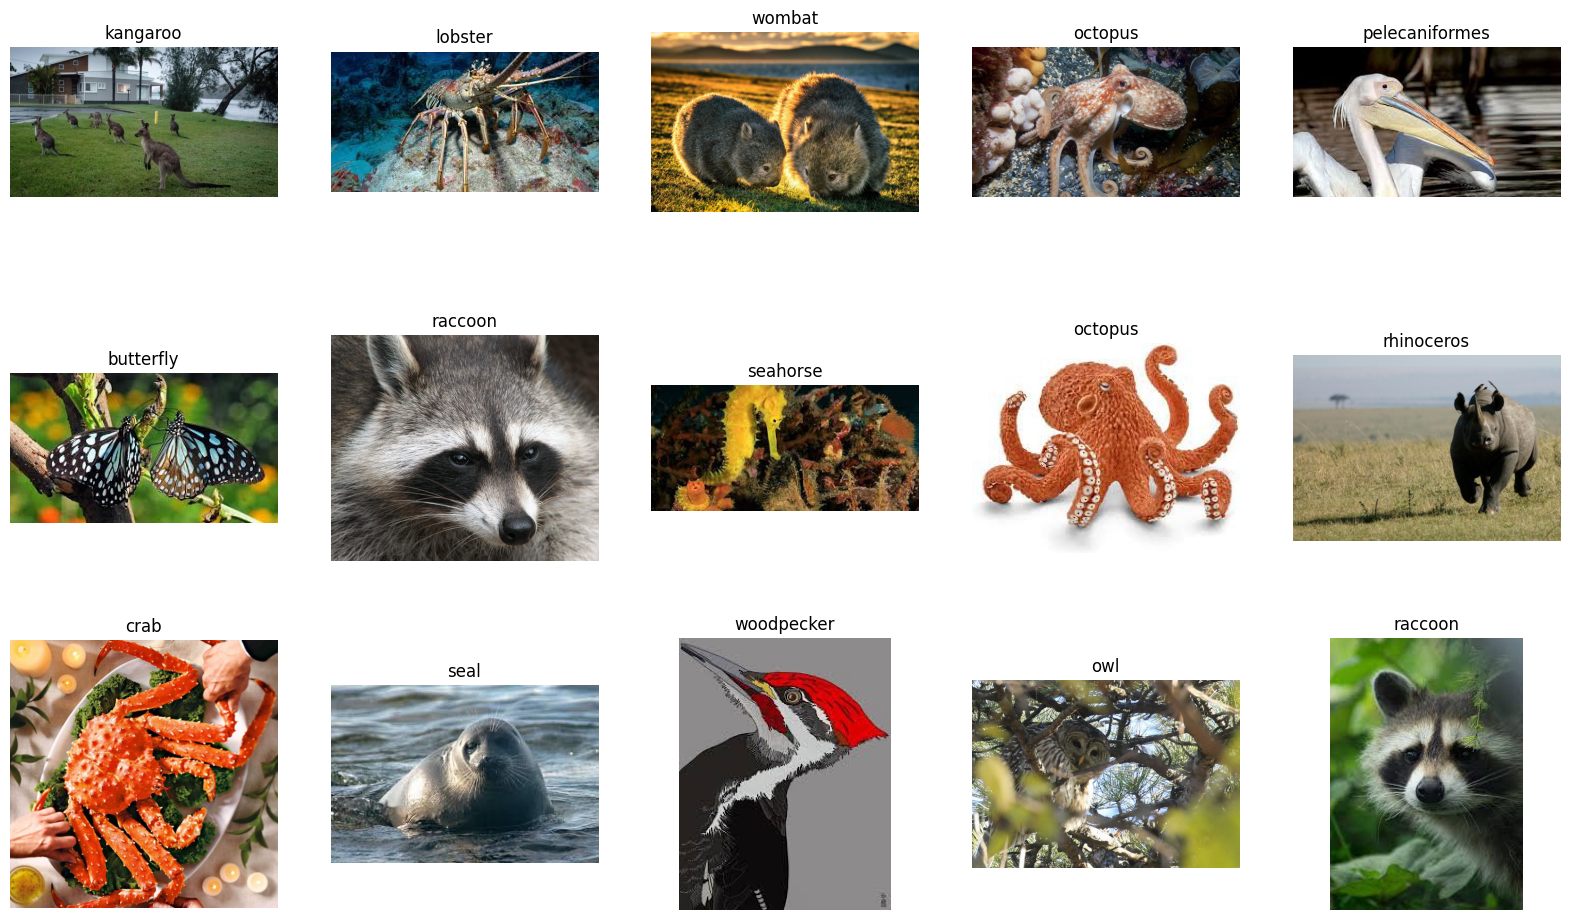

In [22]:
# Zufällige Beispielbilder des Datasets anzeigen lassen inkl. Label.
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # für zufällige Bilder
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows * cols):
        img = samples[i]['image'] 
        label = samples[i]['label']

        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label_names(label))
        plt.axis('off')

    plt.show()

show_samples(dataset['train'],rows=3,cols=5)

In [23]:
# Importiert DatasetDict
from datasets import DatasetDict

# Split in Training- und Test-Daten(80% Train, 20% Test)
split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)

# Aufteilen des Test-Splits in Validation und finalen Test (je 10% des Gesamtdatensatzes)
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5, seed=42)

# DatasetDict erstellen mit drei Splits
our_dataset = DatasetDict({
    'train': split_dataset['train'],        # 80% Training
    'validation': eval_dataset['train'],    # 10% Validation
    'test': eval_dataset['test']            # 10% Test
})

# Ausgabe zur Kontrolle (zeigt Anzahl Elemente pro Split etc.)
print(our_dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4320
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
})


In [24]:
# Prüfen ob genügen Tierklassen pro Split auftauchen

for split in ['train', 'validation', 'test']:
    labels_in_split = set(our_dataset[split]['label'])
    print(f"{split}: {len(labels_in_split)} Klassen")

train: 90 Klassen
validation: 89 Klassen
test: 90 Klassen


### Image Processor


In [25]:
#AutoImageProcessor verwenden
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [26]:
#Data Augmentation: zufällige Transformationen auf den Bildern zum Trainieren – z. B. Drehen, Spiegeln, Farben verändern
train_augmentation = T.Compose([
   #Horizontal spiegeln 
    T.RandomHorizontalFlip(),
    # Leichte Drehung um bis zu 25 Grad
    T.RandomRotation(25),
    # Helligkeit, Kontrast, Sättigung leicht variieren – wirkt wie unterschiedliche Lichtverhältnisse
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])


In [27]:
# Für Augmentation (nur beim Training)

def train_transforms(batch):
    augmented_images = [train_augmentation(img) for img in batch['image']]
    inputs = processor(images=augmented_images, return_tensors="pt")
    inputs['labels'] = batch['label']
    return inputs

In [29]:
# Macht keine Augmentation und wird bei Validation und Test verwendet.
def transforms(batch):
    inputs = processor(batch['image'], return_tensors="pt")
    inputs['labels'] = batch['label']
    return inputs

In [31]:
# Transformationsfunktionen anwenden
processed_dataset = our_dataset.with_transform(transforms) #für validation und test
processed_dataset['train'] = processed_dataset['train'].with_transform(train_transforms) #für train


In [32]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4320
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
})

#### Data Collation

In [33]:
# aus einzelnen Beispielen ein batch bauen
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Metriken berechnen
---

In [34]:
# Accuracy-Metrik aus der evaluate-Bibliothek laden
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1) #wählt höchste Wahrscheinlichkeit 
    score = accuracy.compute(predictions=predictions, references=labels) # vergleicht Vorhersagen mit echten Labels
    return score

## Model laden
---

In [35]:
# IDs und Tiernamen einander zuordnen
label_names = our_dataset['train'].features['label'].names

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

In [36]:
from transformers import ViTForImageClassification

# Vortrainiertes Model wird hier geladen. 

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Zeigt Architektur des Modells
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [38]:
# Alle Parameter im Modell einfrieren ausser Classifier Layer.

for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [39]:
# Alle Parameter zählen
num_params = sum([p.numel() for p in model.parameters()])
# zählt Parameter, die trainiert werden können (also die nicht eingefrorenen)
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,867,866 | trainable_params = 69,210


# Model trainieren
---

In [40]:
# Hier wird Model trainiert
# Batch size : heisst, dass die Bilder in kleinere Batches geteilt werden, da nicht alle auf einmal gehen. 

training_args = TrainingArguments(
    output_dir="./cv_animals",
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
    run_name="cv_animals_transferlearning"
)

In [41]:
#Vorbereitung des Trainers
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    processing_class=processor
)

In [42]:
#Ausführung des Trainings
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.180300,0.321491,0.962963
2,0.277900,0.163361,0.964815
3,0.174500,0.140680,0.964815
4,0.160800,0.132191,0.962963
5,0.148600,0.128135,0.964815


TrainOutput(global_step=1350, training_loss=0.518374801211887, metrics={'train_runtime': 2185.3331, 'train_samples_per_second': 9.884, 'train_steps_per_second': 0.618, 'total_flos': 1.6751471500689408e+18, 'train_loss': 0.518374801211887, 'epoch': 5.0})

In [43]:
# Evaluation des trainierten Modells auf den Testdaten
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.08328360319137573,
 'eval_accuracy': 0.987037037037037,
 'eval_runtime': 12.7273,
 'eval_samples_per_second': 42.428,
 'eval_steps_per_second': 5.343,
 'epoch': 5.0}

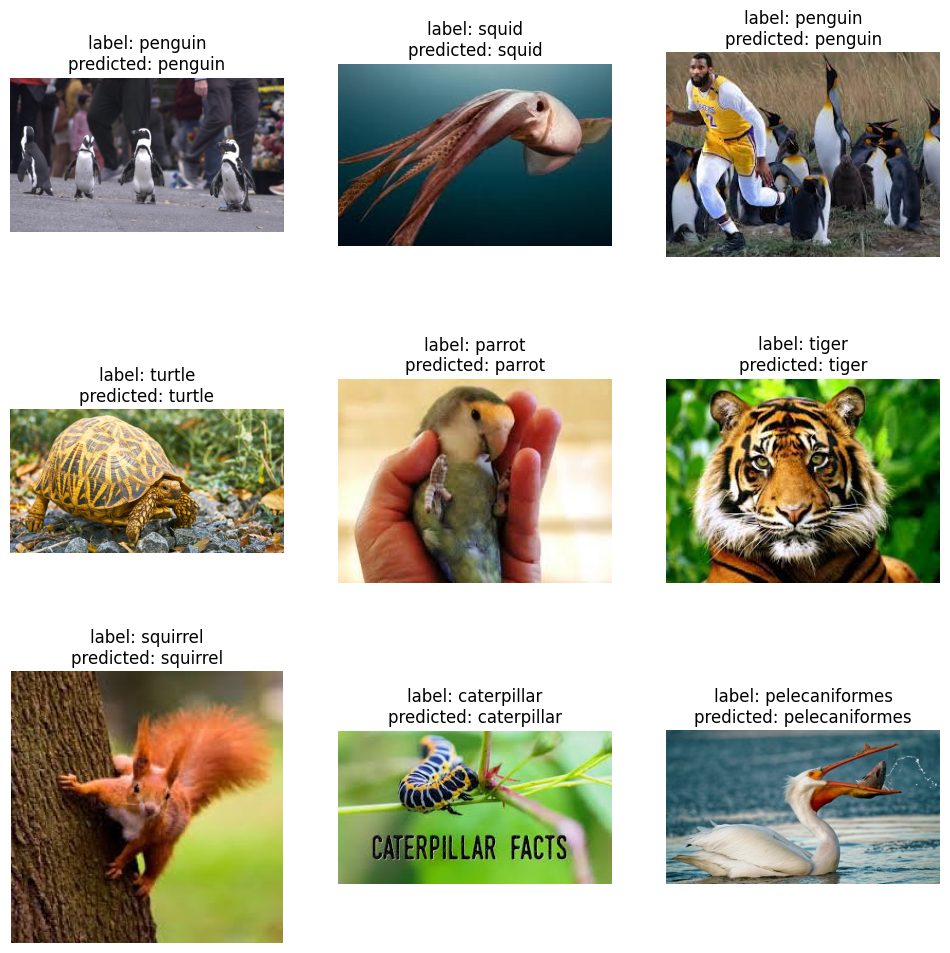

In [47]:
# Beispielbilder mit Vorhersagen und tatsächlichem Label anzeigen lassen
def show_predictions(rows, cols):
    samples = our_dataset['test'].shuffle(seed=42).select(np.arange(rows * cols))

    processed_samples = samples.with_transform(transforms)

    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # Vorhergesagte Labels

    fig = plt.figure(figsize=(cols * 4, rows * 4))
    label_names = our_dataset['train'].features['label'].names

    for i in range(rows * cols):
        img = samples[i]['image']
        true_label = label_names[samples[i]['label']]
        pred_label = label_names[predictions[i]]
        label = f"label: {true_label}\npredicted: {pred_label}"

        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=3,cols=3)

In [48]:
# Metadaten meines Projekts definieren
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "dataset": 'animals',
    "tasks": "image-classification",
    "tags": [
        "image-classification",
        "animals",
        "transfer-learning",
        "vision-transformer",
        "vit",
        "own-dataset",
        "pytorch",
        "huggingface",
    ],
}

In [49]:
# Speicherung des Modells und auf Huggingface hochladen
trainer.save_model()
trainer.push_to_hub('cv_animals', **kwargs)

events.out.tfevents.1748733392.ip-10-192-12-38.2203.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Dalmatiner/cv_animals/commit/37a098457df692ffd6980d4bba039bd5c91bdc06', commit_message='cv_animals', commit_description='', oid='37a098457df692ffd6980d4bba039bd5c91bdc06', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Dalmatiner/cv_animals', endpoint='https://huggingface.co', repo_type='model', repo_id='Dalmatiner/cv_animals'), pr_revision=None, pr_num=None)